In [1]:
import os, sys
import numpy as np
from math import *
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf

from graph_nets import graphs
import networkx as nx
from graph_nets import utils_tf

from graph_network import EncodeProcessDecode

plt.style.use('ggplot') 
plt.style.use('seaborn-paper') 
plt.style.use('seaborn-whitegrid') 

2021-10-22 15:17:47.690089: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Prepare the data

In [2]:
train_dir = 'train_datasets/'
valid_dir = 'valid_datasets/'

feature_description = {'group_id': tf.io.FixedLenFeature([], tf.int64),
                        'timestep': tf.io.FixedLenFeature([], tf.int64),
                        'parameter_vector': tf.io.FixedLenSequenceFeature([], tf.float32,allow_missing=True),
                        'pos': tf.io.FixedLenFeature([], tf.string),
                        'vel': tf.io.FixedLenFeature([], tf.string)}

def _parse_record(x):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(x, feature_description)

def _parse_tensor(x):
    output = {'group_id': x['group_id'],
                'timestep': x['timestep'],
                'parameter_vector': x['parameter_vector'],
                'pos': tf.io.parse_tensor(x['pos'],out_type=tf.float32),
                'vel': tf.io.parse_tensor(x['vel'],out_type=tf.float32)}
    return output

train_dataset =  tf.data.TFRecordDataset(tf.data.Dataset.list_files([train_dir + filename for filename in os.listdir(train_dir)]))

parsed_train_dataset = train_dataset.map(_parse_record)
parsed_train_dataset = parsed_train_dataset.map(_parse_tensor)
parsed_train_dataset = parsed_train_dataset.shuffle(10000, reshuffle_each_iteration=True)
parsed_train_dataset = parsed_train_dataset.batch(32, drop_remainder=True)



valid_dataset =  tf.data.TFRecordDataset(tf.data.Dataset.list_files([valid_dir + filename for filename in os.listdir(valid_dir)]))

parsed_valid_dataset = valid_dataset.map(_parse_record)
parsed_valid_dataset = parsed_valid_dataset.map(_parse_tensor)
parsed_valid_dataset = parsed_valid_dataset.shuffle(10000, reshuffle_each_iteration=True)
parsed_valid_dataset = parsed_valid_dataset.batch(4, drop_remainder=True)


2021-10-22 15:17:48.636785: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-22 15:17:48.637389: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-22 15:17:48.670877: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 15:17:48.671001: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro P1000 computeCapability: 6.1
coreClock: 1.4805GHz coreCount: 5 deviceMemorySize: 3.92GiB deviceMemoryBandwidth: 74.65GiB/s
2021-10-22 15:17:48.671018: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-10-22 15:17:48.672117: I tensorflow/stream_executor/platform/default/dso_lo

## Preprocess positions and velocities into a graph tuple

In [3]:
interaction_scale = 0.25 #(* mean distance between individuals)
L = 200

@tf.function
def preprocess_data(X,V):
    
    # node features xpos, ypos, xvel, yvel
    # edge features distance, rel angle to receiver

    
    Xx = tf.expand_dims(X[...,0],-1)
    dx = -Xx + tf.linalg.matrix_transpose(Xx)
    dx = tf.where(dx>0.5*L, dx-L, dx)
    dx = tf.where(dx<-0.5*L, dx+L, dx)

    Xy = tf.expand_dims(X[...,1],-1)
    dy = -Xy + tf.linalg.matrix_transpose(Xy)
    dy = tf.where(dy>0.5*L, dy-L, dy)
    dy = tf.where(dy<-0.5*L, dy+L, dy)

    Vx = tf.expand_dims(V[...,0],-1)
    dvx = -Vx + tf.linalg.matrix_transpose(Vx)

    Vy = tf.expand_dims(V[...,1],-1)
    dvy = -Vy + tf.linalg.matrix_transpose(Vy)

    A = tf.expand_dims(tf.math.atan2(V[...,1],V[...,0]),-1)
    angle_to_neigh = tf.math.atan2(dy, dx)

    rel_angle_to_neigh = angle_to_neigh - A

    dist = tf.math.sqrt(tf.square(dx)+tf.square(dy))
    #print(tf.reduce_mean(dist,axis=[1,2]))
    interaction_radius = interaction_scale * tf.reduce_mean(dist,axis=[1,2],keepdims=True)
    adj_matrix = tf.where(dist<interaction_radius, tf.ones_like(dist,dtype=tf.int32), tf.zeros_like(dist,dtype=tf.int32))
    adj_matrix = tf.linalg.set_diag(adj_matrix, tf.zeros(tf.shape(adj_matrix)[:2],dtype=tf.int32))
    sender_recv_list = tf.where(adj_matrix)
    n_edge = tf.reduce_sum(adj_matrix, axis=[1,2])
    n_node = tf.ones_like(n_edge)*tf.shape(adj_matrix)[-1]

    senders =tf.squeeze(tf.slice(sender_recv_list,(0,1),size=(-1,1)))+ tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]
    receivers = tf.squeeze(tf.slice(sender_recv_list,(0,2),size=(-1,1))) + tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]


    edge_distance = tf.expand_dims(tf.gather_nd(dist,sender_recv_list),-1)
    edge_x_distance =  tf.expand_dims(tf.gather_nd(tf.math.cos(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading
    edge_y_distance =  tf.expand_dims(tf.gather_nd(tf.math.sin(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading

    edge_x_orientation =  tf.expand_dims(tf.gather_nd(dvx,sender_recv_list),-1)  # neigbour velocity relative to sender heading
    edge_y_orientation =  tf.expand_dims(tf.gather_nd(dvy,sender_recv_list),-1)  # neigbour velocity relative to sender heading


    edges = tf.concat([edge_distance,edge_x_distance,edge_y_distance,edge_x_orientation,edge_y_orientation],axis=-1)

    node_positions = tf.reshape(X,(-1,2))
    node_velocities = tf.reshape(V,(-1,2))

    nodes = tf.concat([node_positions,node_velocities],axis=-1)

    gn = graphs.GraphsTuple(nodes=nodes,edges=edges,globals=None,receivers=receivers,senders=senders,n_node=n_node,n_edge=n_edge)
    gn = utils_tf.set_zero_global_features(gn,1)
    
    return gn

## Set up the optimizer and the loss function

In [59]:
min_lr = 1e-6
lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4 - min_lr,
                                decay_steps=int(5e6),
                                decay_rate=0.1) #+ min_lr
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

loss_function = tf.keras.losses.MeanSquaredError()


In [60]:
min_params = np.array([0.0],dtype=np.float32)
max_params = np.array([25.0],dtype=np.float32)

#max_params = np.array([1.0,25.0,25.0,2*pi],dtype=np.float32)
#min_params = np.zeros_like(max_params)
max_params = np.array([25.0,25],dtype=np.float32)
min_params = np.zeros_like(max_params)
epd = EncodeProcessDecode(latent_size=128,mlp_hidden_size=128,mlp_num_hidden_layers=2,num_message_passing_steps=10,output_size=2, output_min=min_params,  output_max=max_params)

In [61]:
# input_graphs = preprocess_data(X,V)
# epd(input_graphs)

## to do replace MLP with keras

# for databatch in  parsed_tensors_dataset:
        
#     X = databatch['pos']
#     V = databatch['vel']
#     input_graphs = preprocess_data(X,V)
#     break

In [62]:
# input_signature = [utils_tf.specs_from_graphs_tuple(input_graphs)]

In [63]:
# @tf.function()#input_signature=input_signature)
# def predict_graph(input_graphs):
#     return epd(input_graphs)
    

In [64]:
# predict_graph.experimental_get_tracing_count()

In [65]:
# epochs = 20

# for epoch in range(epochs):
#     pbar = tqdm(parsed_tensors_dataset)
#     epoch_loss = 0
#     c = 0 
#     # Iterate over the batches of the dataset.
#     for databatch in  pbar:
#         target = databatch['parameter_vector'][:,2]
#         X = databatch['pos']
#         V = databatch['vel']
        
#         input_graphs = preprocess_data(X,V)

#         #break
#         loss_value = train_step(X,V,target).numpy()
#         epoch_loss+= loss_value
#         c+=1
#         pbar.set_description("Loss %f" % (epoch_loss/c))

In [66]:
@tf.function()
def train_step(X,V,target):
   
    input_graphs = preprocess_data(X,V)

    with tf.GradientTape() as tape:
        predictions = epd(input_graphs)
        loss_value = loss_function(target,predictions)
    grads = tape.gradient(loss_value, epd.trainable_variables)
    optimizer.apply_gradients(zip(grads, epd.trainable_variables))
    return loss_value

In [67]:
#predict_graph.experimental_get_tracing_count()

In [68]:
#input_graphs = preprocess_data(X,V)
#input_graphs

## Run the training

In [76]:
epochs = 20

for epoch in range(epochs):
    pbar = tqdm(parsed_train_dataset)
    epoch_loss = 0
    c = 0 
    # Iterate over the batches of the dataset.
    for databatch in  pbar:
        target = databatch['parameter_vector'][:,1:3]
        X = databatch['pos']
        V = databatch['vel']
        
        if train_step.experimental_get_tracing_count()==0:
            input_graphs = preprocess_data(X,V)
            predictions = epd(input_graphs)
            #input_signature = [utils_tf.specs_from_graphs_tuple(input_graphs,dynamic_num_nodes=False)]
            #@tf.function(input_signature=input_signature)
            #def predict_graph(input_graphs):
            #    return epd(input_graphs)
        #break
        loss_value = train_step(X,V,target).numpy()
        epoch_loss+= loss_value
        c+=1
        pbar.set_description("Loss %f" % (epoch_loss/c))
    


Loss 28.784548: : 695it [02:51,  4.05it/s]
Loss 25.863515: : 695it [02:51,  4.06it/s]
Loss 24.085112: : 695it [02:51,  4.05it/s]
Loss 22.979180: : 695it [02:52,  4.04it/s]
Loss 21.423974: : 695it [02:51,  4.05it/s]
Loss 19.857637: : 695it [02:51,  4.06it/s]
Loss 19.446475: : 695it [02:51,  4.06it/s]
Loss 18.308944: : 695it [02:51,  4.06it/s]
Loss 12.928141: : 5it [00:01,  3.11it/s]


KeyboardInterrupt: 

In [77]:
#input_graphs = preprocess_data(X,V)

In [78]:
#input_graphs

In [79]:
# target

In [80]:
# aa = epd(input_graphs)

In [81]:
# loss_function(target,aa)

In [82]:
# aa

In [83]:
# target[:,2,None]

In [84]:
# target-aa

In [85]:
# tf.reduce_mean(tf.math.square(target-aa))

In [86]:
pred_list = []
true_values = []
count=0
for databatch in tqdm(parsed_valid_dataset):
    true_values.append(databatch['parameter_vector'].numpy())
    X = databatch['pos']
    V = databatch['vel']
    input_graphs = preprocess_data(X,V)
    predictions = epd(input_graphs)
    pred_list.append(np.squeeze(predictions.numpy()))
    count+=1

    if count == 100: break
pred_vals = np.array(pred_list)#.flatten()
true_vals = np.array(true_values)#.flatten()




99it [00:02, 42.86it/s]


In [71]:
x_val = []
pred_mean = []
pred_std = []
for tv in np.unique(true_vals):
    pred_mean.append(pred_vals[true_vals==tv].mean())
    pred_std.append(pred_vals[true_vals==tv].std())
    x_val.append(tv)
    
pred_mean = np.array(pred_mean)
pred_std = np.array(pred_std)
x_val = np.array(x_val)

IndexError: boolean index did not match indexed array along dimension 2; dimension is 2 but corresponding boolean dimension is 4

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(x_val,pred_mean,c='C0')

plt.fill_between(x_val,pred_mean-pred_std,pred_mean+pred_std,color='C0',alpha=0.5)

xx = np.linspace(0,x_val.max(),10)
plt.plot(xx,xx,c='k',ls='--')

plt.ylabel('GNN prediction of parameter')
plt.xlabel('True parameter that generated the microstate')
plt.savefig('gnn.png',dpi=300)
plt.show()


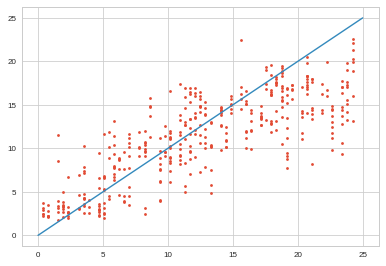

In [87]:
plt.plot(true_vals[:,:,1].flatten(),pred_vals[:,:,0].flatten(),'.')
xx = np.linspace(0,25,10)
plt.plot(xx,xx)
plt.show()

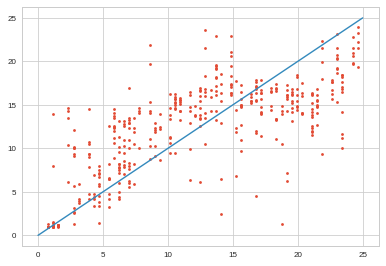

In [89]:
plt.plot(true_vals[:,:,2].flatten(),pred_vals[:,:,1].flatten(),'.')
xx = np.linspace(0,25,10)
plt.plot(xx,xx)
plt.show()

In [32]:
pred_vals[:,:]

array([[13.902199 , 15.632822 , 12.025795 , 13.897321 ],
       [12.3725195, 14.8625555, 11.428269 , 12.093476 ],
       [12.945575 , 11.4643   , 12.828146 , 11.470286 ],
       [15.692706 , 15.431839 , 14.305942 , 14.728579 ],
       [13.1061735, 11.649303 , 12.942446 , 12.656384 ],
       [14.774187 , 12.540472 , 14.088032 , 12.357711 ],
       [14.665776 , 12.855476 , 15.576394 , 15.476627 ],
       [11.611262 ,  3.2339606, 14.488609 , 15.086959 ],
       [ 3.5839   , 11.71521  , 12.943784 , 12.937659 ],
       [15.560287 , 12.370864 , 12.219812 , 11.765519 ],
       [13.590709 , 15.643742 , 14.546153 , 12.696342 ],
       [14.311236 , 15.26397  , 11.654345 , 11.726391 ],
       [12.503998 , 13.332525 , 15.235603 , 15.633455 ],
       [13.253609 , 15.160857 , 11.787132 , 15.131458 ],
       [12.95207  , 15.529726 , 13.058943 , 14.684788 ],
       [13.088155 , 15.599209 , 15.831794 ,  4.681457 ],
       [11.587858 , 15.373063 , 15.313901 , 13.366749 ],
       [15.351695 , 13.180487 ,

In [ ]:
pbar = tqdm(parsed_tensors_dataset)

# Iterate over the batches of the dataset.
for d in  pbar:
    mygraph = preprocess_data(d)
    break

In [ ]:
mygraph

In [ ]:
utils_tf.get_num_graphs(mygraph)

num_graphs = utils_tf.get_num_graphs(mygraph)
graph_index = tf.range(num_graphs)
indices = utils_tf.repeat(graph_index, mygraph.n_node, axis=0)#,
                              #sum_repeats_hint=_get_static_num_nodes(graph))
tf.math.unsorted_segment_sum(mygraph.nodes, indices, num_graphs)

In [ ]:
indices

In [ ]:
?tf.math.unsorted_segment_sum

In [ ]:
tf.repeat(graph_index, mygraph.n_node,axis=0)

In [ ]:
epd._output_transform

In [ ]:
   # Encode the input_graph.
latent_graph_0 = epd._encode(input_graphs)

# Do `m` message passing steps in the latent graphs.
latent_graph_m = epd._process(latent_graph_0)
decode_graph_m = epd._decode(latent_graph_m)
    # Decode from the last latent graph.
    #return self._output_transform(decode_graph_m.globals)

In [ ]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Dense(8))
model2.add(tf.keras.layers.LayerNormalization(axis=1))
model2.build(input_shape=(128,))

In [ ]:
model.summary()

In [ ]:
decode_graph_m.globals

In [ ]:
model(decode_graph_m.globals)

In [ ]:
epd._output_size

In [ ]:
# Create a `Sequential` model and add a Dense layer as the first layer.
model = tf.keras.models.Sequential()

for _ in range(epd._mlp_num_hidden_layers):
    model.add(tf.keras.layers.Dense(epd._mlp_hidden_size, activation='relu'))

model.add(tf.keras.layers.Dense(epd._output_size,activation=tf.nn.softplus))
